In [3]:
import pandas as pd

# Load English and German data
df_ger = pd.read_excel("C:/Users/vyache/Downloads/Features_German.xlsx")

# Inspect data
print(df_ger.head())



  Speaker   Recording  F0_sma_de_amean_mean  F0_sma_de_skewness_mean  \
0   Rec 1  SPEAKER_00             -0.025850                -0.020843   
1   Rec 1  SPEAKER_01              0.012883                -0.004928   
2   Rec 2  SPEAKER_00              0.015668                -0.006627   
3   Rec 2  SPEAKER_01              0.015564                 0.003007   
4   Rec 3  SPEAKER_00              0.024351                -0.007949   

   pcm_intensity_sma_amean_mean  pcm_intensity_sma_de_amean_mean  \
0                  3.964125e+00                         0.000005   
1                  2.577363e+10                    486969.725000   
2                  2.841074e+09                     67442.583333   
3                  3.052068e+00                    185303.337500   
4                  3.914474e+01                         0.018160   

   pcm_loudness_sma_amean_mean  pcm_loudness_sma_de_amean_mean  \
0                     0.713777                    7.939195e+00   
1                     0.65

In [4]:
# Convert columns with commas to float
cols_to_convert = ["pcm_intensity_sma_amean_mean", "pcm_intensity_sma_de_amean_mean", "pcm_loudness_sma_amean_mean", "pcm_loudness_sma_de_amean_mean"]

for df in [df_ger]:
    for col in cols_to_convert:
        df[col] = df[col].astype(str).str.replace(",", ".").astype(float)


In [7]:
from sklearn.preprocessing import StandardScaler

# Select only numerical features
feature_cols = df_ger.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()

# Apply standardization separately for English
df_ger[feature_cols] = scaler.fit_transform(df_ger[feature_cols])


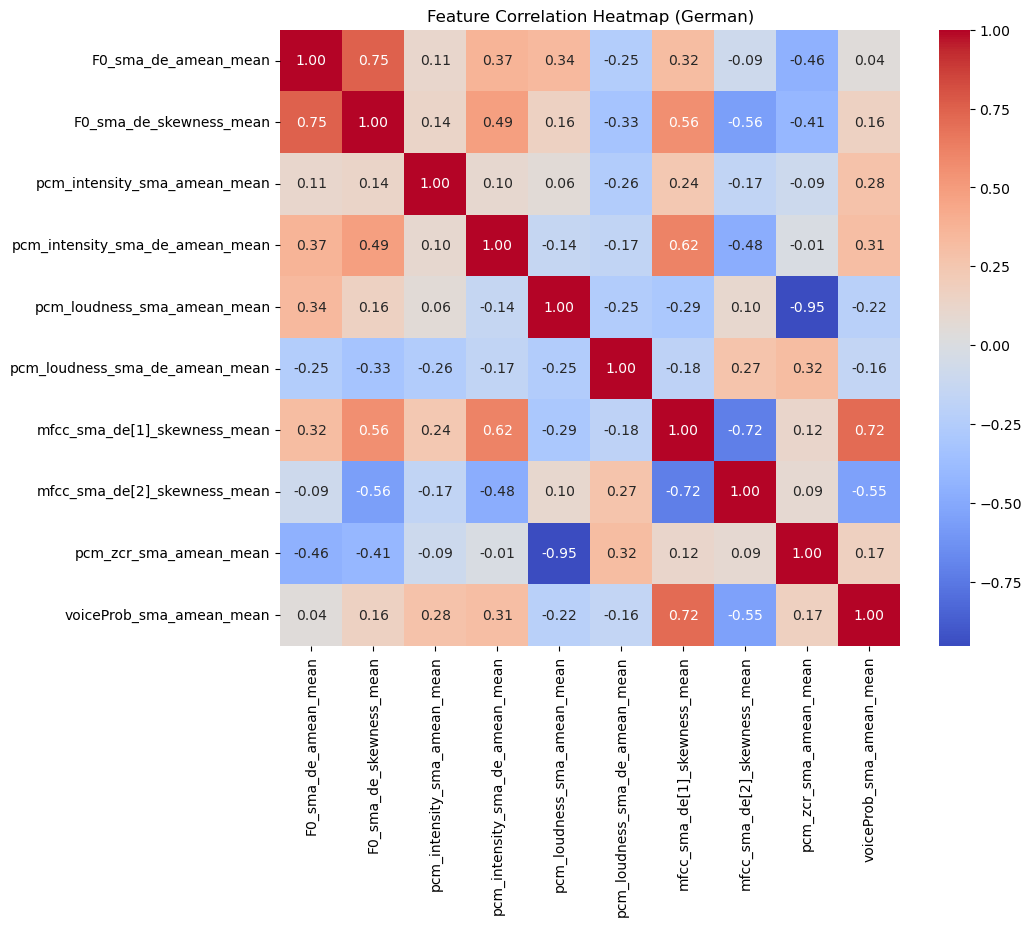

In [9]:
# Select only numeric columns
numeric_cols = df_ger.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix only for numeric columns
correlation_matrix = df_ger[numeric_cols].corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (German)")
plt.show()


In [10]:
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=5)  # Adjust the number of components as needed
principal_components = pca.fit_transform(df_ger[feature_cols])

# Convert to DataFrame
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(5)])
print(df_pca.head())

# Check explained variance
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")


        PC1       PC2       PC3       PC4       PC5
0  1.330320  6.332323 -0.647576  2.815806  1.508876
1 -3.999643  8.419665 -0.592909 -0.647249 -0.757842
2  0.384372  3.625467  1.814722 -1.526439  0.673216
3  1.024621  1.797163  2.990198 -2.570066  1.636958
4  1.304275  0.675378  2.486721 -2.153084  1.097761
Explained Variance Ratio: [0.35674308 0.25572536 0.11694758 0.08003411 0.07002804]


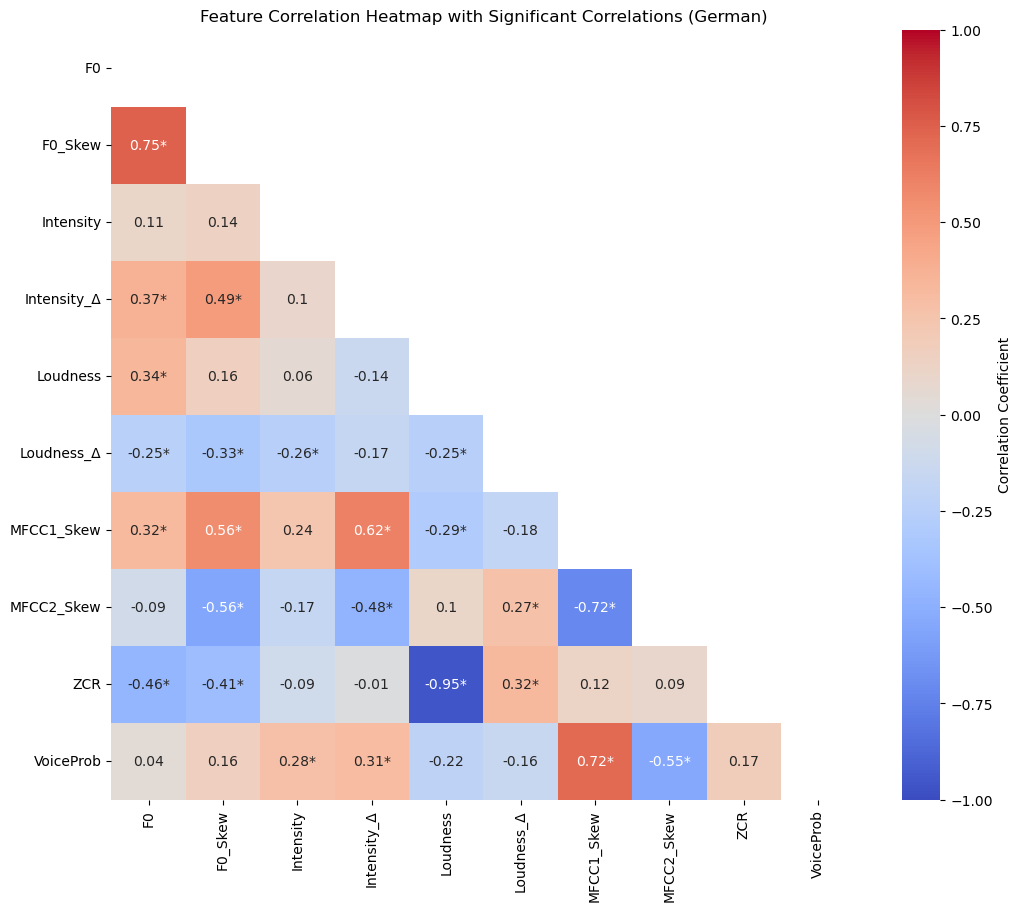

In [11]:
from scipy.stats import pearsonr
import numpy as np

# Define clean variable names
rename_dict = {
    'F0_sma_de_amean_mean': 'F0',
    'F0_sma_de_skewness_mean': 'F0_Skew',
    'pcm_intensity_sma_amean_mean': 'Intensity',
    'pcm_intensity_sma_de_amean_mean': 'Intensity_Δ',
    'pcm_loudness_sma_amean_mean': 'Loudness',
    'pcm_loudness_sma_de_amean_mean': 'Loudness_Δ',
    'mfcc_sma_de[1]_skewness_mean': 'MFCC1_Skew',
    'mfcc_sma_de[2]_skewness_mean': 'MFCC2_Skew',
    'pcm_zcr_sma_amean_mean': 'ZCR',
    'voiceProb_sma_amean_mean': 'VoiceProb'
}

# Step 1: Compute correlation and p-values
def calculate_corr_pvals(df):
    corr = df.corr()
    pvals = pd.DataFrame(np.zeros_like(corr), columns=corr.columns, index=corr.index)

    for row in corr.columns:
        for col in corr.columns:
            if row != col:
                r, p = pearsonr(df[row], df[col])
                pvals.loc[row, col] = p
            else:
                pvals.loc[row, col] = np.nan  # Diagonal
    return corr, pvals

corr_matrix, pval_matrix = calculate_corr_pvals(df_ger[numeric_cols])

# Step 2: Create significance stars
def significance_stars(pvals):
    stars = pvals.copy().astype(str)
    stars[:] = ''
    stars[pvals < 0.05] = '*'
    return stars

stars = significance_stars(pval_matrix)
# Rename rows and columns for clarity
corr_matrix.rename(columns=rename_dict, index=rename_dict, inplace=True)
pval_matrix.rename(columns=rename_dict, index=rename_dict, inplace=True)
stars = significance_stars(pval_matrix)

# Step 4: Combine correlation values with significance stars
annot_matrix = corr_matrix.round(2).astype(str) + stars

# Step 3: Plot heatmap with stars
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask

# Plot heatmap with both values and stars
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=annot_matrix, fmt='', vmin=-1, vmax=1, center=0,
            cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={"size": 10})
plt.title("Feature Correlation Heatmap with Significant Correlations (German)")
plt.savefig('C:/Users/vyache/Desktop/heatmap_significant_corr_ger.png', dpi=300, bbox_inches='tight')
plt.show()

Columns in dataset: ['Speaker', 'Recording', 'F0_sma_de_amean_mean', 'F0_sma_de_skewness_mean', 'pcm_intensity_sma_amean_mean', 'pcm_intensity_sma_de_amean_mean', 'pcm_loudness_sma_amean_mean', 'pcm_loudness_sma_de_amean_mean', 'mfcc_sma_de[1]_skewness_mean', 'mfcc_sma_de[2]_skewness_mean', 'pcm_zcr_sma_amean_mean', 'voiceProb_sma_amean_mean']


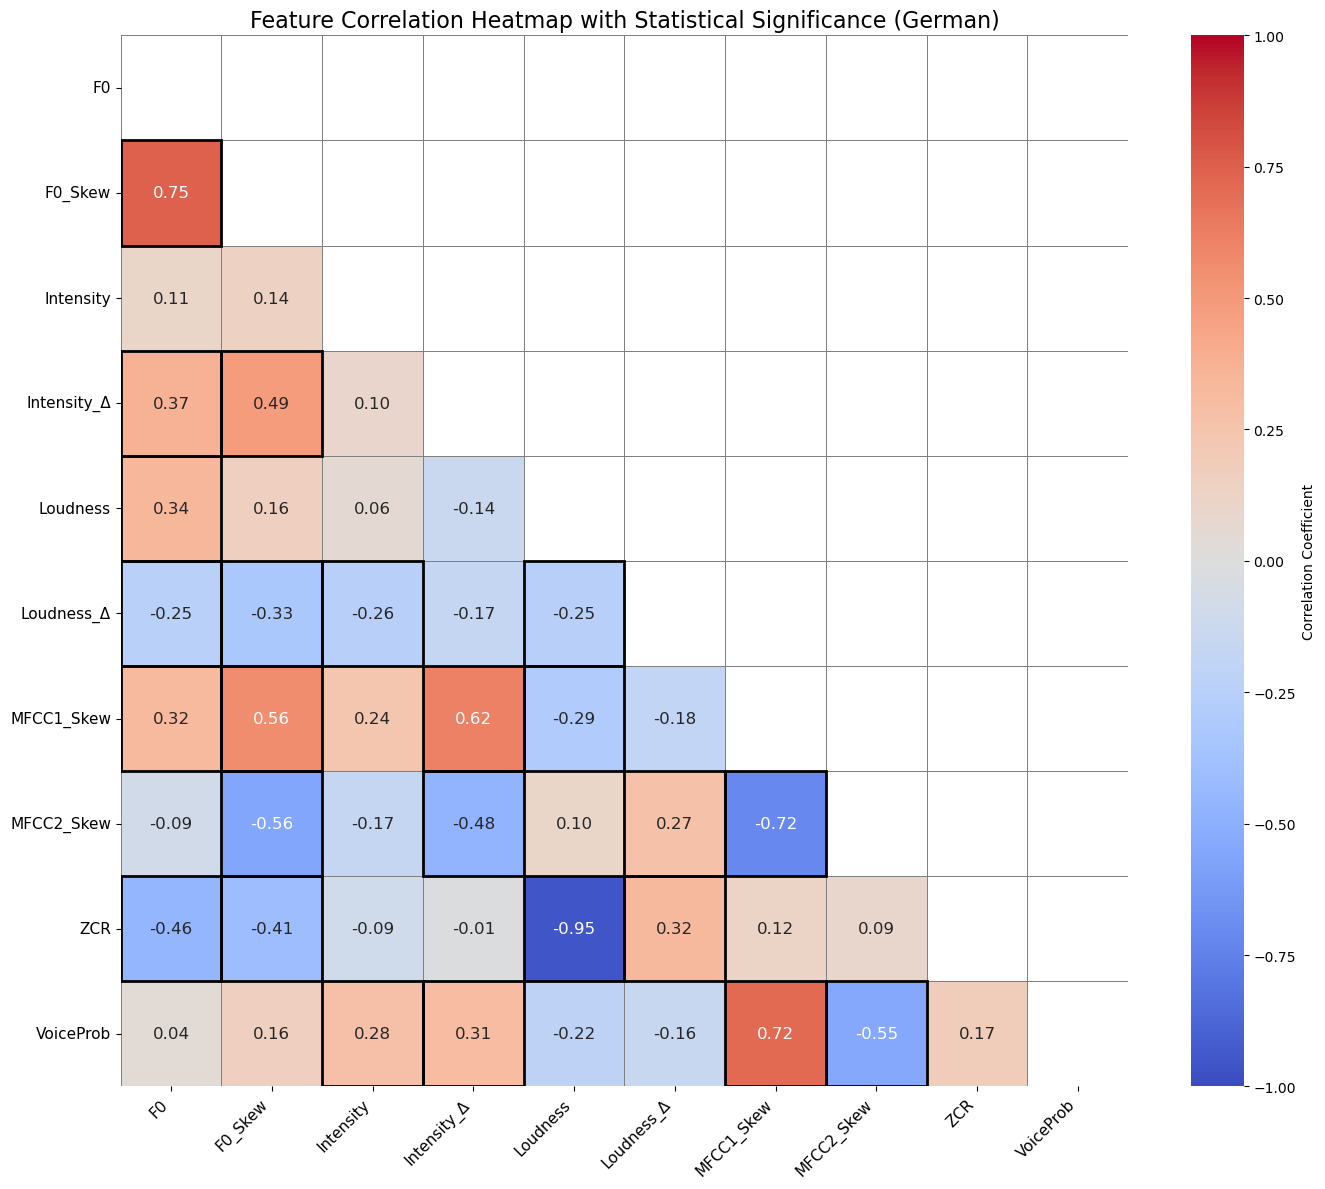

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1. Load and inspect data
# -------------------------------
df = pd.read_excel("C:/Users/vyache/Downloads/Features_German.xlsx")
print("Columns in dataset:", df.columns.tolist())

# -------------------------------
# 2. Define rename dictionary with safety check
# -------------------------------
rename_dict = {
    'F0_sma_de_amean_mean': 'F0',
    'F0_sma_de_skewness_mean': 'F0_Skew',
    'pcm_intensity_sma_amean_mean': 'Intensity',
    'pcm_intensity_sma_de_amean_mean': 'Intensity_Δ',
    'pcm_loudness_sma_amean_mean': 'Loudness',
    'pcm_loudness_sma_de_amean_mean': 'Loudness_Δ',
    'mfcc_sma_de[1]_skewness_mean': 'MFCC1_Skew',
    'mfcc_sma_de[2]_skewness_mean': 'MFCC2_Skew',
    'pcm_zcr_sma_amean_mean': 'ZCR',
    'voiceProb_sma_amean_mean': 'VoiceProb'
}

# Keep only available columns
available_features = {k: v for k, v in rename_dict.items() if k in df.columns}
missing = set(rename_dict.keys()) - set(available_features.keys())
if missing:
    print(f"⚠️ Warning: Missing columns not found in data and will be skipped: {missing}")

# -------------------------------
# 3. Data Cleaning & Scaling
# -------------------------------
# Convert comma to dot in numeric columns (if present)
for col in available_features:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

# Scale
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[available_features.keys()]),
                         columns=available_features.values())

# -------------------------------
# 4. Compute correlation and p-values
# -------------------------------
def compute_corr_pvals(df):
    corr = df.corr()
    pvals = pd.DataFrame(np.nan, index=corr.index, columns=corr.columns)
    for i in corr.columns:
        for j in corr.columns:
            if i != j:
                _, p = pearsonr(df[i], df[j])
                pvals.loc[i, j] = p
    return corr, pvals

corr, pvals = compute_corr_pvals(df_scaled)

# -------------------------------
# 5. Plotting with significance highlight
# -------------------------------
mask = np.triu(np.ones_like(corr, dtype=bool))
signif_mask = (pvals < 0.05) & ~mask

plt.figure(figsize=(14, 12))
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Correlation Coefficient'},
    annot_kws={"size": 12}  # Increase size of numbers
)

# Highlight statistically significant cells with black border
for i in range(len(corr)):
    for j in range(len(corr.columns)):
        if signif_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

plt.title("Feature Correlation Heatmap with Statistical Significance (German)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.savefig("C:/Users/vyache/Desktop/german_corr_highlighted_600dpi.png", dpi=600, bbox_inches='tight')
plt.show()
